In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read csv file
df = pd.read_csv("X:/research paper-implementation/PJMW_hourly_preprocessed_XGBoost.csv",parse_dates=['Datetime'], index_col='Datetime')

In [3]:
df

,PJMW_MW,hour,day_of_week,month
Datetime,,,,
2002-04-01 01:00:00,4374.0,1,0,4
2002-04-01 02:00:00,4306.0,2,0,4
2002-04-01 03:00:00,4322.0,3,0,4
2002-04-01 04:00:00,4359.0,4,0,4
2002-04-01 05:00:00,4436.0,5,0,4
...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,3,8
2018-08-02 21:00:00,6496.0,21,3,8
2018-08-02 22:00:00,6325.0,22,3,8


In [4]:
df = df.sort_index()

In [5]:
# drop unnecessary columns
df = df.drop(columns=['hour', 'day_of_week', 'month']) ## i saw in graph they were not imporant in this model at last code cell

In [6]:
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


### 2. Feature Engineering

In [7]:
# Scale target separately
target_scaler = MinMaxScaler()
df['PJMW_MW_scaled'] = target_scaler.fit_transform(df[['PJMW_MW']])

# Lag features using SCALED target
for lag in [1, 2, 24, 168]:
    df[f'lag_{lag}'] = df['PJMW_MW_scaled'].shift(lag)

# 5. Train-test split
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# Rolling mean on SCALED data
train['rolling_24h_mean'] = train['PJMW_MW_scaled'].rolling(24).mean()
test['rolling_24h_mean'] = test['PJMW_MW_scaled'].rolling(24).mean()

features = [
            'lag_1', 'lag_2', 'lag_24', 'lag_168',
            'rolling_24h_mean']
target = 'PJMW_MW_scaled'

# Drop NA (from lag features)
train = train.dropna()
test = test.dropna()

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [8]:

df

,PJMW_MW,PJMW_MW_scaled,lag_1,lag_2,lag_24,lag_168
Datetime,,,,,,
2002-04-01 01:00:00,4374.0,0.426815,NaN,NaN,NaN,NaN
2002-04-01 02:00:00,4306.0,0.419348,0.426815,NaN,NaN,NaN
2002-04-01 03:00:00,4322.0,0.421105,0.419348,0.426815,NaN,NaN
2002-04-01 04:00:00,4359.0,0.425167,0.421105,0.419348,NaN,NaN
2002-04-01 05:00:00,4436.0,0.433622,0.425167,0.421105,NaN,NaN
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,0.665203,0.681454,0.688591,0.694960,0.754035
2018-08-02 21:00:00,6496.0,0.659822,0.665203,0.681454,0.668058,0.722082
2018-08-02 22:00:00,6325.0,0.641045,0.659822,0.665203,0.645108,0.703635


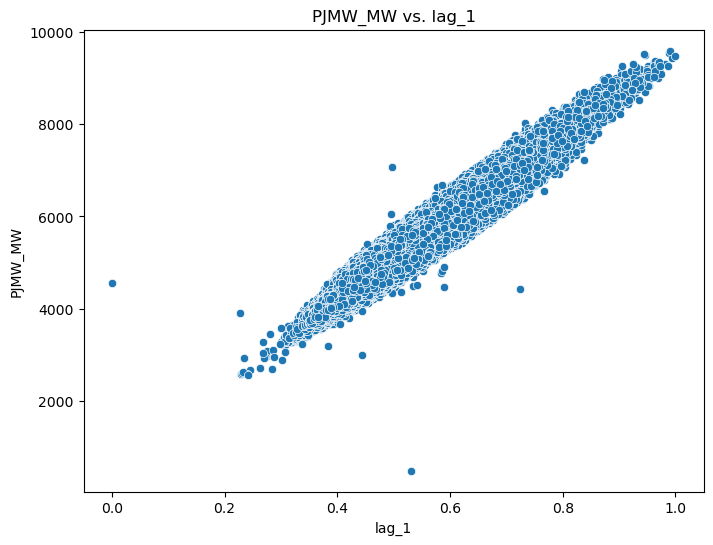

In [9]:
#visualize lag_1 vs. target 
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['lag_1'], y=df['PJMW_MW'])
plt.title('PJMW_MW vs. lag_1')
plt.xlabel('lag_1')
plt.ylabel('PJMW_MW')
plt.show()

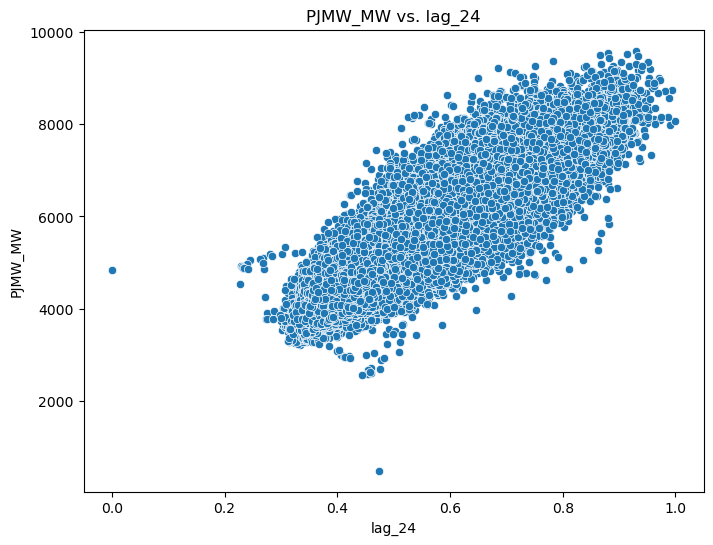

In [10]:
# another one to visualize lag_24 vs. target 
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['lag_24'], y=df['PJMW_MW'])
plt.title('PJMW_MW vs. lag_24')
plt.xlabel('lag_24')
plt.ylabel('PJMW_MW')
plt.show()


### 3. Hyperparameter Tuning with GridSearchCV ( will take few minutes 1-5 min)

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Parameter grid (simplified for faster tuning)
param_grid = {
    'max_depth': [4, 6,8,10,12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.4,0.6,0.8, 1.0]
}

# Time-series CV
tscv = TimeSeriesSplit(n_splits=3)

# Model WITHOUT early stopping in GridSearch
model = XGBRegressor(
    n_estimators=200,  # Reduced for tuning speed
    objective='reg:squarederror',
    random_state=42
)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)  # No early stopping here

print("\nBest parameters:", grid.best_params_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'subsample': 0.6}


### 4. Train Final Model with Best Parameters

In [12]:
best_model = XGBRegressor(
    **grid.best_params_,
    n_estimators=1000,
    early_stopping_rounds=20,
    eval_metric='mae',
    random_state=42
)

# Use last 20% of train as validation
val_size = int(len(X_train) * 0.2)
X_train_final, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_final, y_val = y_train[:-val_size], y_train[-val_size:]
print (f"Training on {len(X_train_final)} samples, validating on {len(X_val)} samples")
print (f"Training features shape: {X_train_final.shape}, Validation features shape: {X_val.shape}")
print (f"Training target shape: {y_train_final.shape}, Validation target shape: {y_val.shape}")

best_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],
    verbose=10
)
print (f"best_model.best_iteration: {best_model.best_iteration}")

Training on 91536 samples, validating on 22884 samples
Training features shape: (91536, 5), Validation features shape: (22884, 5)
Training target shape: (91536,), Validation target shape: (22884,)
[0]	validation_0-mae:0.08634
[10]	validation_0-mae:0.05300
[20]	validation_0-mae:0.03327
[30]	validation_0-mae:0.02183
[40]	validation_0-mae:0.01552
[50]	validation_0-mae:0.01225
[60]	validation_0-mae:0.01070
[70]	validation_0-mae:0.01000
[80]	validation_0-mae:0.00970
[90]	validation_0-mae:0.00957
[100]	validation_0-mae:0.00951
[110]	validation_0-mae:0.00948
[120]	validation_0-mae:0.00946
[130]	validation_0-mae:0.00946
[140]	validation_0-mae:0.00945
[150]	validation_0-mae:0.00946
[160]	validation_0-mae:0.00945
[170]	validation_0-mae:0.00945
[180]	validation_0-mae:0.00944
[190]	validation_0-mae:0.00944
[199]	validation_0-mae:0.00944
best_model.best_iteration: 179


### 5. Evaluation

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict using XGBoost model
y_pred = best_model.predict(X_test)

# Scaled evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
test_mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100  # safer MAPE

# Print scaled metrics
print(f"Test MAE (scaled): {test_mae:.4f}")
print(f"Test RMSE (scaled): {test_rmse:.4f}")
print(f"Test R² (scaled): {test_r2:.4f}")

# Convert MAE and RMSE to original scale (MW)
mw_range = df['PJMW_MW'].max() - df['PJMW_MW'].min()
mae_mw = test_mae * mw_range
rmse_mw = test_rmse * mw_range

# Print metrics in MW and MAPE
print(f"Test MAE: {mae_mw:.2f} MW (scaled: {test_mae:.4f})")
print(f"Test RMSE: {rmse_mw:.2f} MW (scaled: {test_rmse:.4f})")
print(f"Test MAPE: {test_mape:.2f}%")

#Add symmetric MAPE (sMAPE) which is more stable for time series
smape = 100 * np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred) + 1e-10))
print(f"Test sMAPE: {smape:.2f}%")


Test MAE (scaled): 0.0088
Test RMSE (scaled): 0.0119
Test R² (scaled): 0.9882
Test MAE: 80.26 MW (scaled: 0.0088)
Test RMSE: 108.09 MW (scaled: 0.0119)
Test MAPE: 1.58%
Test sMAPE: 1.58%


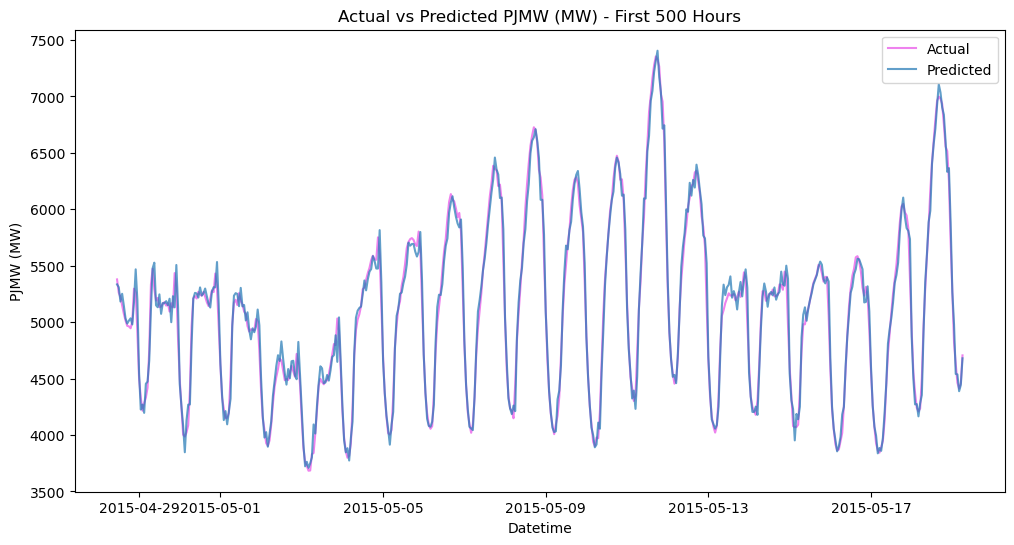

In [19]:
# Assuming you have X_train and y_train prepared
model.fit(X_train, y_train)  # Train the model
# Make predictions (assuming you have a trained model called 'model')
predictions = model.predict(X_test)  # Replace X_test with your actual test features

# Then proceed with your plotting code
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:500], target_scaler.inverse_transform(y_test.values[:500].reshape(-1, 1)), 
         label='Actual', color='violet')
plt.plot(y_test.index[:500], target_scaler.inverse_transform(predictions[:500].reshape(-1, 1)), 
         label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted PJMW (MW) - First 500 Hours')
plt.xlabel('Datetime')
plt.ylabel('PJMW (MW)')
plt.legend()
plt.show()

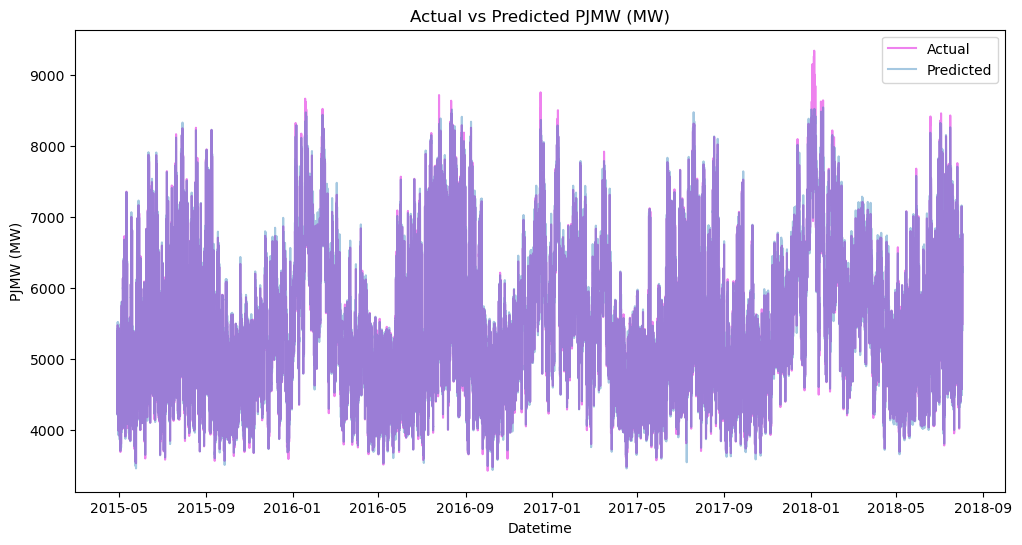

In [ ]:
# plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, target_scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Actual', color='violet')
predictions = best_model.predict(X_test)
plt.plot(y_test.index, target_scaler.inverse_transform(predictions.reshape(-1, 1)), label='Predicted', alpha=0.4)
plt.title('Actual vs Predicted PJMW (MW)')
plt.xlabel('Datetime')
plt.ylabel('PJMW (MW)')
plt.legend()
plt.show()


### 6. Feature Importance

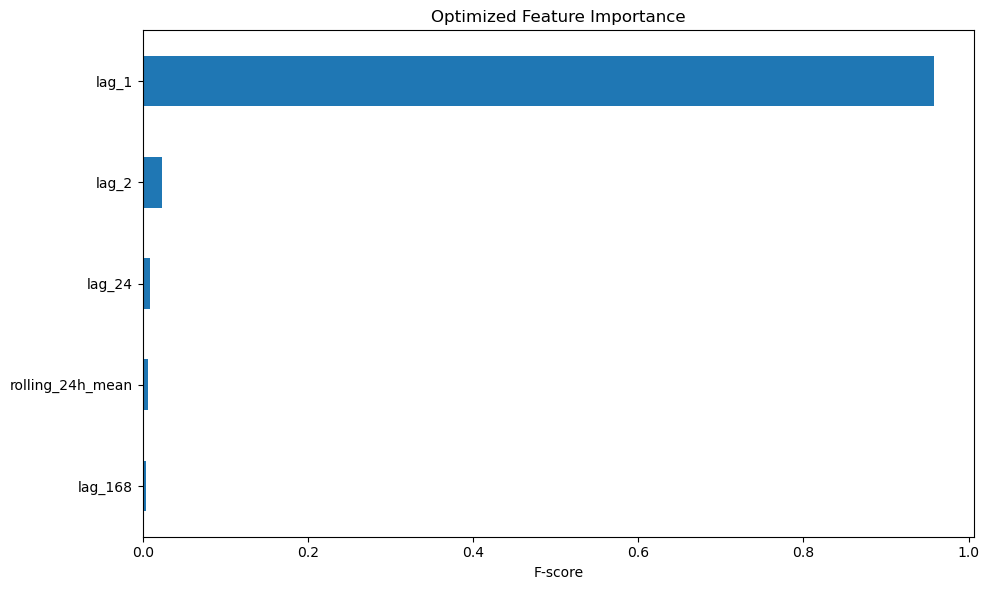

In [ ]:
plt.figure(figsize=(10,6))
pd.Series(best_model.feature_importances_, index=features).sort_values()\
    .plot(kind='barh', title='Optimized Feature Importance')
plt.xlabel("F-score")
plt.tight_layout()
plt.show()

In [ ]:
if train.index[-val_size-1] < train.index[-val_size]:
    print("✅ No overlap (good)")
else:
    print("❌ Overlap (bad)")


✅ No overlap (good)
